# Chapter 15 

# Setup

In [1]:
#tensorflow
import tensorflow as tf
from tensorflow import keras

#sklearn
import sklearn
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Common imports
import numpy as np
import pandas as pd
import os
import os.path
import urllib

# To plot pretty figures
import matplotlib.pyplot as plt

In [1702]:
def plot_learning_curve( history ):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    ymin, ymax = [], []
    for x in history.history.keys():
        ymax.append( max(history.history[x]))
        ymin.append( min(history.history[x]))
    plt.gca().set_ylim(min(ymin), max(ymax))
    plt.xlabel("EPOCHS")
    plt.show()

In [1703]:
def plot_actual_pred( actual, prediction ):
    plt.plot(actual, ".-", alpha=.6, label="Actual")
    plt.plot(prediction, ".-", alpha=.6, label="Prediction")
    plt.grid(True)
    plt.legend()
    plt.show()

In [1704]:
def plot_forecast(Y, Y_pred, Y_actual=None):
    n_steps = Y.shape[0]
    ahead = Y_pred.shape[0]
    plt.plot(Y,"b-", alpha=.6)
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred, "rx-", label="Forecast")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_actual, "b.-", label="Actual")
    plt.legend()
    plt.grid()

In [1705]:
#define a metric that provides the MSE on the last step only (the real test for this squential learning that is happening)
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

## Source Data

In [1743]:
#download data files if not currently found in your datasets directory (under the current working directory)
DOWNLOAD_DIR = "datasets/"
filename = "FAANG.csv"

#download the needed file from the class github repository
if not os.path.isfile(DOWNLOAD_DIR+filename):
    DOWNLOAD_ROOT = " https://raw.githubusercontent.com/SueMcMetzger/MachineLearning/main/chpt15/"
    url = DOWNLOAD_ROOT + filename
    urllib.request.urlretrieve(url, DOWNLOAD_DIR+filename)
    print("Downloaded", filename)  
        
#create a dataframe with the data from the CSV file
data = pd.read_csv(DOWNLOAD_DIR+filename)

In [1744]:
data

,Date,FB_CLOSE,AMZN_CLOSE,AAPL_CLOSE,NFLX_CLOSE,GOOG_CLOSE,GSPC_CLOSE
0,2012-05-18,38.23,213.85,16.316,9.994,299.079,1295.22
1,2012-05-21,34.03,218.11,17.267,10.249,305.908,1315.99
2,2012-05-22,31.00,215.33,17.134,9.673,299.278,1316.63
3,2012-05-23,32.00,217.28,17.552,10.273,303.592,1318.86
4,2012-05-24,33.03,215.24,17.391,10.039,300.703,1320.68
...,...,...,...,...,...,...,...
2165,2020-12-24,267.40,3172.69,131.773,513.970,1738.850,3703.06
2166,2020-12-28,277.00,3283.96,136.486,519.120,1776.090,3735.36
2167,2020-12-29,276.78,3322.00,134.669,530.870,1758.720,3727.04
2168,2020-12-30,271.87,3285.85,133.520,524.590,1739.520,3732.04


In [1745]:
data

,Date,FB_CLOSE,AMZN_CLOSE,AAPL_CLOSE,NFLX_CLOSE,GOOG_CLOSE,GSPC_CLOSE
0,2012-05-18,38.23,213.85,16.316,9.994,299.079,1295.22
1,2012-05-21,34.03,218.11,17.267,10.249,305.908,1315.99
2,2012-05-22,31.00,215.33,17.134,9.673,299.278,1316.63
3,2012-05-23,32.00,217.28,17.552,10.273,303.592,1318.86
4,2012-05-24,33.03,215.24,17.391,10.039,300.703,1320.68
...,...,...,...,...,...,...,...
2165,2020-12-24,267.40,3172.69,131.773,513.970,1738.850,3703.06
2166,2020-12-28,277.00,3283.96,136.486,519.120,1776.090,3735.36
2167,2020-12-29,276.78,3322.00,134.669,530.870,1758.720,3727.04
2168,2020-12-30,271.87,3285.85,133.520,524.590,1739.520,3732.04


In [1746]:
#create new features to deepen the learning and memory from previous S&P prices

data = pd.DataFrame(data)
data['t_minus1'] = data.GSPC_CLOSE.shift(+1)
data['t_minus2'] = data.GSPC_CLOSE.shift(+2)
data['t_minus3'] = data.GSPC_CLOSE.shift(+3)
data['t_minus4'] = data.GSPC_CLOSE.shift(+4)
data.head(10)

,Date,FB_CLOSE,AMZN_CLOSE,AAPL_CLOSE,NFLX_CLOSE,GOOG_CLOSE,GSPC_CLOSE,t_minus1,t_minus2,t_minus3,t_minus4
0,2012-05-18,38.23,213.85,16.316,9.994,299.079,1295.22,NaN,NaN,NaN,NaN
1,2012-05-21,34.03,218.11,17.267,10.249,305.908,1315.99,1295.22,NaN,NaN,NaN
2,2012-05-22,31.00,215.33,17.134,9.673,299.278,1316.63,1315.99,1295.22,NaN,NaN
3,2012-05-23,32.00,217.28,17.552,10.273,303.592,1318.86,1316.63,1315.99,1295.22,NaN
4,2012-05-24,33.03,215.24,17.391,10.039,300.703,1320.68,1318.86,1316.63,1315.99,1295.22
5,2012-05-25,31.91,212.89,17.298,10.031,294.661,1317.82,1320.68,1318.86,1316.63,1315.99
6,2012-05-29,28.84,214.75,17.605,9.920,296.060,1332.42,1317.82,1320.68,1318.86,1316.63
7,2012-05-30,28.19,209.23,17.817,9.620,293.017,1313.32,1332.42,1317.82,1320.68,1318.86
8,2012-05-31,29.60,212.91,17.773,9.063,289.345,1310.33,1313.32,1332.42,1317.82,1320.68
9,2012-06-01,27.72,208.22,17.258,8.993,284.424,1278.04,1310.33,1313.32,1332.42,1317.82


In [1747]:
data=data[5:]

In [1748]:
data

,Date,FB_CLOSE,AMZN_CLOSE,AAPL_CLOSE,NFLX_CLOSE,GOOG_CLOSE,GSPC_CLOSE,t_minus1,t_minus2,t_minus3,t_minus4
5,2012-05-25,31.91,212.89,17.298,10.031,294.661,1317.82,1320.68,1318.86,1316.63,1315.99
6,2012-05-29,28.84,214.75,17.605,9.920,296.060,1332.42,1317.82,1320.68,1318.86,1316.63
7,2012-05-30,28.19,209.23,17.817,9.620,293.017,1313.32,1332.42,1317.82,1320.68,1318.86
8,2012-05-31,29.60,212.91,17.773,9.063,289.345,1310.33,1313.32,1332.42,1317.82,1320.68
9,2012-06-01,27.72,208.22,17.258,8.993,284.424,1278.04,1310.33,1313.32,1332.42,1317.82
...,...,...,...,...,...,...,...,...,...,...,...
2165,2020-12-24,267.40,3172.69,131.773,513.970,1738.850,3703.06,3690.01,3687.26,3694.92,3709.41
2166,2020-12-28,277.00,3283.96,136.486,519.120,1776.090,3735.36,3703.06,3690.01,3687.26,3694.92
2167,2020-12-29,276.78,3322.00,134.669,530.870,1758.720,3727.04,3735.36,3703.06,3690.01,3687.26
2168,2020-12-30,271.87,3285.85,133.520,524.590,1739.520,3732.04,3727.04,3735.36,3703.06,3690.01


In [4385]:
#scale the data using MinMaxScaler
#challenge here is that we need to preserve the scaler used on the labeled data for future predictions
#as well as understanding how well the model is performing

#scaler used for features
scaler = MinMaxScaler()
priorScaler=MinMaxScaler()

#scaler for labeled data
indexScaler = MinMaxScaler()

scaled_data = np.concatenate([scaler.fit_transform(data[['FB_CLOSE','AMZN_CLOSE','AAPL_CLOSE','NFLX_CLOSE','GOOG_CLOSE']]), 
                              priorScaler.fit_transform(data[['t_minus1','t_minus2','t_minus3','t_minus4']]),
                                  indexScaler.fit_transform(data[['GSPC_CLOSE']])], axis = 1)



In [4386]:
#look at the shape of our scaled_data
scaled_data.shape

(2165, 10)

In [4387]:
#let's determine the number of features in our data
#we need this information for building out our model in the future
num_features = scaled_data.shape[1]
num_features

10

In [4388]:
#take a look at the first 5 entries that will be the "features" for this model
scaled_data[0:5]

array([[0.04954923, 0.00140526, 0.04108773, 0.00427246, 0.01044202,
        0.01735224, 0.01661159, 0.0157041 , 0.01552503, 0.01605307],
       [0.03882172, 0.00196496, 0.04355767, 0.00407023, 0.01134488,
        0.01618837, 0.01735224, 0.01661159, 0.01578685, 0.02194485],
       [0.03655042, 0.00030392, 0.04526328, 0.00352364, 0.00938104,
        0.0221298 , 0.01618837, 0.01735224, 0.01669912, 0.01423712],
       [0.04147739, 0.00141128, 0.04490929, 0.00250882, 0.00701125,
        0.0143571 , 0.0221298 , 0.01618837, 0.01744367, 0.01303051],
       [0.0349081 , 0.        , 0.04076592, 0.00238128, 0.00383541,
        0.01314033, 0.0143571 , 0.0221298 , 0.01627367, 0.        ]])

In [4389]:
#take a look at the first 15 entries in the data that will be used as the labeled data (y) for our model
#NOTE: that num_features-1 after the commas indicateds to select the last column in our dataset as the labeled data
Y = pd.DataFrame(scaled_data[:,num_features-1])
Y['t_plus1'] = Y[0].shift(-1)
Y.head(10)

,0,t_plus1
0,0.016053,0.021945
1,0.021945,0.014237
2,0.014237,0.013031
3,0.013031,0.000000
4,0.000000,0.000056
5,0.000056,0.003010
6,0.003010,0.014968
7,0.014968,0.014911
8,0.014911,0.019217
9,0.019217,0.012466


In [4390]:
Y.tail()

,0,t_plus1
2160,0.978608,0.991643
2161,0.991643,0.988285
2162,0.988285,0.990303
2163,0.990303,1.000000
2164,1.000000,NaN


In [4391]:
Y.dropna(inplace=True)

In [4392]:
Y = Y.to_numpy()

In [4393]:
scaled_data[0:15,num_features-1]

array([1.60530744e-02, 2.19448514e-02, 1.42371158e-02, 1.30305121e-02,
       0.00000000e+00, 5.64964912e-05, 3.01045589e-03, 1.49675347e-02,
       1.49110382e-02, 1.92168779e-02, 1.24655472e-02, 1.86196293e-02,
       1.48666481e-02, 2.06050774e-02, 2.61498045e-02])

In [4394]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_data[:-1,], Y[:,1:], test_size=0.05, random_state=42, shuffle = False)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size=0.75, random_state=42, shuffle = False)

In [4395]:

STEPS = 1

In [4396]:
trainSeries = keras.preprocessing.sequence.TimeseriesGenerator(X_train, y_train, length=STEPS, batch_size=100)
testSeries = keras.preprocessing.sequence.TimeseriesGenerator(X_test, y_test, length=STEPS, batch_size=100)
validSeries = keras.preprocessing.sequence.TimeseriesGenerator(X_valid,y_valid,length=STEPS, batch_size=100)

In [4397]:
#let's look at a few items in a timeseries to understand what LAG means 
#and how data is structured for processing
for i in range(3):
    a,b= trainSeries[i]
    print('%s => %s' % (a, b))

[[[4.95492347e-02 1.40525934e-03 4.10877348e-02 4.27246094e-03
   1.04420174e-02 1.73522374e-02 1.66115931e-02 1.57041004e-02
   1.55250282e-02 1.60530744e-02]]

 [[3.88217206e-02 1.96495578e-03 4.35576652e-02 4.07022505e-03
   1.13448841e-02 1.61883678e-02 1.73522374e-02 1.66115931e-02
   1.57868469e-02 2.19448514e-02]]

 [[3.65504228e-02 3.03921185e-04 4.52632849e-02 3.52364156e-03
   9.38103619e-03 2.21297999e-02 1.61883678e-02 1.73522374e-02
   1.66991213e-02 1.42371158e-02]]

 [[4.14773919e-02 1.41127758e-03 4.49092884e-02 2.50881821e-03
   7.01125324e-03 1.43571045e-02 2.21297999e-02 1.61883678e-02
   1.74436681e-02 1.30305121e-02]]

 [[3.49080998e-02 0.00000000e+00 4.07659198e-02 2.38128207e-03
   3.83540851e-03 1.31403317e-02 1.43571045e-02 2.21297999e-02
   1.62736660e-02 0.00000000e+00]]

 [[3.20427703e-02 1.91079161e-03 4.15785028e-02 2.91511194e-03
   6.28198997e-03 0.00000000e+00 1.31403317e-02 1.43571045e-02
   2.22464041e-02 5.64964912e-05]]

 [[2.84436369e-02 1.50155120

# Baselines

In [4398]:


#predcition is based on last observed value
pred= indexScaler.inverse_transform( y_test[1:,].reshape(-1,1) )
actual= indexScaler.inverse_transform( y_test[:-1,].reshape(-1,1) )

#calculate the Mean Absolute Error between the prediction and the actual
naive = np.mean(keras.losses.mean_absolute_error(pred,actual))
naive

28.273981481481457

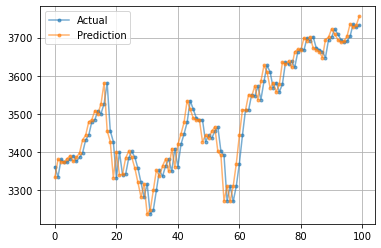

In [4399]:
plot_actual_pred (actual[-100:,0], pred[-100:,0])

# GRU

In [4400]:
#starting by setting random seeds and restarting keras blackend session
np.random.seed(42)
tf.random.set_seed(42)

#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

In [4401]:
#now let's try this using LSTMs which by its nature takes into consideration 
#long-term trends as well as learning from newer data
#we just changed our RNN layers to LSTM layers

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=(STEPS, num_features)),
    keras.layers.GRU(10, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

In [4402]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1, 20)             1920      
_________________________________________________________________
gru_1 (GRU)                  (None, 1, 10)             960       
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 1)              11        
Total params: 2,891
Trainable params: 2,891
Non-trainable params: 0
_________________________________________________________________


In [4403]:
#define early stopping
#this is not necessary BUT helps models run faster
#define what early stopping means - in this case, when the validation loss after 2 iterations hasn't changed
#after defining, it can be added to any model fitting using the parameter callbacks (see next step)
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode='min', min_delta=.000001)

In [4404]:
#compile the model and use the new metric defined in the previous step
model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.00005), metrics=[last_time_step_mse])

#fit the model
history = model.fit(trainSeries, epochs=500, shuffle=False, 
                    validation_data=validSeries, callbacks=[early_stopping])

Epoch 1/500
6/6 [==============================] - 3s 130ms/step - loss: 0.0122 - last_time_step_mse: 0.0138 - val_loss: 0.1991 - val_last_time_step_mse: 0.2077
Epoch 2/500
6/6 [==============================] - 0s 15ms/step - loss: 0.0118 - last_time_step_mse: 0.0134 - val_loss: 0.1957 - val_last_time_step_mse: 0.2041
Epoch 3/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0115 - last_time_step_mse: 0.0130 - val_loss: 0.1923 - val_last_time_step_mse: 0.2006
Epoch 4/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0111 - last_time_step_mse: 0.0126 - val_loss: 0.1889 - val_last_time_step_mse: 0.1970
Epoch 5/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0107 - last_time_step_mse: 0.0122 - val_loss: 0.1855 - val_last_time_step_mse: 0.1936
Epoch 6/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0104 - last_time_step_mse: 0.0118 - val_loss: 0.1822 - val_last_time_step_mse: 0.1901
Epoch 7/500
6/6 [======================

Epoch 52/500
6/6 [==============================] - 0s 12ms/step - loss: 0.0025 - last_time_step_mse: 0.0030 - val_loss: 0.0770 - val_last_time_step_mse: 0.0807
Epoch 53/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0024 - last_time_step_mse: 0.0029 - val_loss: 0.0755 - val_last_time_step_mse: 0.0791
Epoch 54/500
6/6 [==============================] - 0s 10ms/step - loss: 0.0024 - last_time_step_mse: 0.0029 - val_loss: 0.0741 - val_last_time_step_mse: 0.0777
Epoch 55/500
6/6 [==============================] - 0s 14ms/step - loss: 0.0023 - last_time_step_mse: 0.0028 - val_loss: 0.0727 - val_last_time_step_mse: 0.0762
Epoch 56/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0023 - last_time_step_mse: 0.0028 - val_loss: 0.0713 - val_last_time_step_mse: 0.0748
Epoch 57/500
6/6 [==============================] - 0s 12ms/step - loss: 0.0023 - last_time_step_mse: 0.0027 - val_loss: 0.0700 - val_last_time_step_mse: 0.0734
Epoch 58/500
6/6 [================

Epoch 103/500
6/6 [==============================] - 0s 10ms/step - loss: 0.0024 - last_time_step_mse: 0.0025 - val_loss: 0.0326 - val_last_time_step_mse: 0.0342
Epoch 104/500
6/6 [==============================] - 0s 10ms/step - loss: 0.0024 - last_time_step_mse: 0.0025 - val_loss: 0.0321 - val_last_time_step_mse: 0.0338
Epoch 105/500
6/6 [==============================] - 0s 12ms/step - loss: 0.0024 - last_time_step_mse: 0.0025 - val_loss: 0.0317 - val_last_time_step_mse: 0.0333
Epoch 106/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0024 - last_time_step_mse: 0.0025 - val_loss: 0.0313 - val_last_time_step_mse: 0.0329
Epoch 107/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0024 - last_time_step_mse: 0.0025 - val_loss: 0.0309 - val_last_time_step_mse: 0.0325
Epoch 108/500
6/6 [==============================] - 0s 11ms/step - loss: 0.0024 - last_time_step_mse: 0.0025 - val_loss: 0.0305 - val_last_time_step_mse: 0.0320
Epoch 109/500
6/6 [=========

Epoch 204/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0019 - last_time_step_mse: 0.0020 - val_loss: 0.0115 - val_last_time_step_mse: 0.0120
Epoch 205/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0019 - last_time_step_mse: 0.0019 - val_loss: 0.0114 - val_last_time_step_mse: 0.0119
Epoch 206/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0019 - last_time_step_mse: 0.0019 - val_loss: 0.0113 - val_last_time_step_mse: 0.0117
Epoch 207/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0019 - last_time_step_mse: 0.0019 - val_loss: 0.0112 - val_last_time_step_mse: 0.0116
Epoch 208/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0019 - last_time_step_mse: 0.0019 - val_loss: 0.0110 - val_last_time_step_mse: 0.0115
Epoch 209/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0019 - last_time_step_mse: 0.0019 - val_loss: 0.0109 - val_last_time_step_mse: 0.0114
Epoch 210/500
6/6 [=========

Epoch 305/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0010 - last_time_step_mse: 0.0010 - val_loss: 0.0026 - val_last_time_step_mse: 0.0026
Epoch 306/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0010 - last_time_step_mse: 0.0010 - val_loss: 0.0025 - val_last_time_step_mse: 0.0026
Epoch 307/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0010 - last_time_step_mse: 0.0010 - val_loss: 0.0025 - val_last_time_step_mse: 0.0025
Epoch 308/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0010 - last_time_step_mse: 0.0010 - val_loss: 0.0024 - val_last_time_step_mse: 0.0025
Epoch 309/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0010 - last_time_step_mse: 0.0010 - val_loss: 0.0024 - val_last_time_step_mse: 0.0024
Epoch 310/500
6/6 [==============================] - 0s 13ms/step - loss: 0.0010 - last_time_step_mse: 0.0010 - val_loss: 0.0023 - val_last_time_step_mse: 0.0024
Epoch 311/500
6/6 [=========

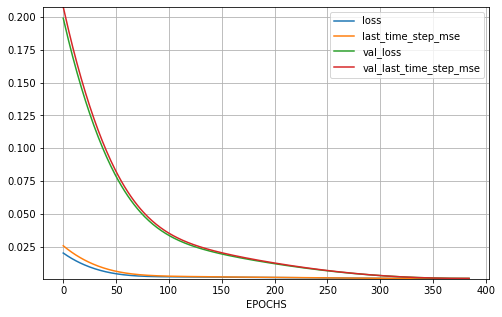

In [4406]:
#plot the learning curve of the model
plot_learning_curve(history)
plt.show()

In [4407]:
y_pred = model.predict(testSeries)

In [4408]:
actual = indexScaler.inverse_transform( y_test[:-STEPS] )
pred = indexScaler.inverse_transform( y_pred[:,0] )

np.mean(keras.losses.mean_absolute_error( actual, pred))

56.68255

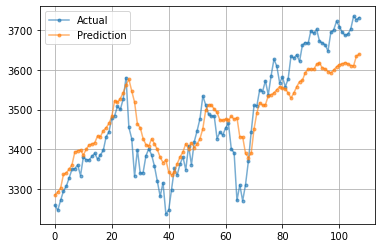

In [4409]:
#plot the actual values vs. the predictions
plot_actual_pred ( actual[:,0], pred[:,0] )


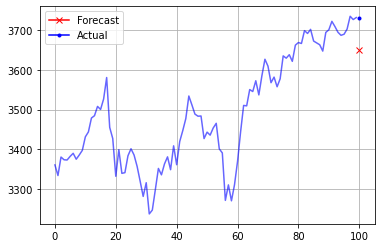

In [4315]:
#forecast the next X items in the sequence
plot_forecast(actual[-100:,0], pred[-1], actual[-1] )

# Predict Next 5 Days

In [5244]:
#take a look at the first 15 entries in the data that will be used as the labeled data (y) for our model
#NOTE: that num_features-1 after the commas indicateds to select the last column in our dataset as the labeled data
Y2 = pd.DataFrame(scaled_data[:,num_features-1])
Y2['t_plus1'] = Y2[0].shift(-1)
Y2['t_plus2'] = Y2[0].shift(-2)
Y2['t_plus3'] = Y2[0].shift(-3)
Y2['t_plus4'] = Y2[0].shift(-4)
Y2['t_plus5'] = Y2[0].shift(-5)
Y2.head(10)

,0,t_plus1,t_plus2,t_plus3,t_plus4,t_plus5
0,0.016053,0.021945,0.014237,0.013031,0.000000,0.000056
1,0.021945,0.014237,0.013031,0.000000,0.000056,0.003010
2,0.014237,0.013031,0.000000,0.000056,0.003010,0.014968
3,0.013031,0.000000,0.000056,0.003010,0.014968,0.014911
4,0.000000,0.000056,0.003010,0.014968,0.014911,0.019217
5,0.000056,0.003010,0.014968,0.014911,0.019217,0.012466
6,0.003010,0.014968,0.014911,0.019217,0.012466,0.018620
7,0.014968,0.014911,0.019217,0.012466,0.018620,0.014867
8,0.014911,0.019217,0.012466,0.018620,0.014867,0.020605
9,0.019217,0.012466,0.018620,0.014867,0.020605,0.026150


In [5245]:
Y2.tail()

,0,t_plus1,t_plus2,t_plus3,t_plus4,t_plus5
2160,0.978608,0.991643,0.988285,0.990303,1.0,NaN
2161,0.991643,0.988285,0.990303,1.000000,NaN,NaN
2162,0.988285,0.990303,1.000000,NaN,NaN,NaN
2163,0.990303,1.000000,NaN,NaN,NaN,NaN
2164,1.000000,NaN,NaN,NaN,NaN,NaN


In [5246]:
Y2.dropna(inplace=True)

In [5247]:
Y2 = Y2.to_numpy()

In [5248]:
Y2.shape

(2160, 6)

In [5249]:
scaled_data[0:15,num_features-1]

array([1.60530744e-02, 2.19448514e-02, 1.42371158e-02, 1.30305121e-02,
       0.00000000e+00, 5.64964912e-05, 3.01045589e-03, 1.49675347e-02,
       1.49110382e-02, 1.92168779e-02, 1.24655472e-02, 1.86196293e-02,
       1.48666481e-02, 2.06050774e-02, 2.61498045e-02])

In [5250]:
# split into train and test sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(scaled_data[:-5,], Y2[:,1:], test_size=0.40, random_state=42, shuffle = False)
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X_train2,y_train2, test_size=0.40, random_state=42, shuffle = False)

In [5251]:
X_train2.shape, X_valid2.shape, X_test2.shape, y_train2.shape

((777, 10), (519, 10), (864, 10), (777, 5))

In [5252]:
trainSeries2 = keras.preprocessing.sequence.TimeseriesGenerator(X_train2, y_train2, length=2, batch_size=1)
testSeries2 = keras.preprocessing.sequence.TimeseriesGenerator(X_test2, y_test2, length=2, batch_size=1)
validSeries2 = keras.preprocessing.sequence.TimeseriesGenerator(X_valid2,y_valid2,length=2, batch_size=1)

In [5253]:
#starting by setting random seeds and restarting keras blackend session
np.random.seed(42)
tf.random.set_seed(42)

#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

In [5254]:
model2 = keras.models.Sequential([
    keras.layers.GRU(100, return_sequences=True, input_shape=(2, num_features)),
    keras.layers.GRU(10, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(5))
])

In [5255]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 2, 100)            33600     
_________________________________________________________________
gru_1 (GRU)                  (None, 2, 10)             3360      
_________________________________________________________________
time_distributed (TimeDistri (None, 2, 5)              55        
Total params: 37,015
Trainable params: 37,015
Non-trainable params: 0
_________________________________________________________________


In [5256]:
#define early stopping
#this is not necessary BUT helps models run faster
#define what early stopping means - in this case, when the validation loss after 2 iterations hasn't changed
#after defining, it can be added to any model fitting using the parameter callbacks (see next step)
early_stoppingB = keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode='min', min_delta=.0001)

In [5257]:
#compile the model and use the new metric defined in the previous step
model2.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.0001), metrics=[last_time_step_mse])

#fit the model
history2 = model2.fit(trainSeries2, epochs=500, shuffle=False, 
                    validation_data=validSeries2, callbacks=[early_stoppingB])

Epoch 1/500
775/775 [==============================] - 6s 3ms/step - loss: 5.7163e-04 - last_time_step_mse: 3.1899e-04 - val_loss: 0.0010 - val_last_time_step_mse: 0.0013
Epoch 2/500
775/775 [==============================] - 2s 2ms/step - loss: 0.0020 - last_time_step_mse: 0.0022 - val_loss: 8.6709e-04 - val_last_time_step_mse: 9.5654e-04
Epoch 3/500
775/775 [==============================] - 2s 2ms/step - loss: 0.0011 - last_time_step_mse: 0.0012 - val_loss: 8.8744e-04 - val_last_time_step_mse: 8.8214e-04
Epoch 4/500
775/775 [==============================] - 2s 2ms/step - loss: 6.4525e-04 - last_time_step_mse: 6.6855e-04 - val_loss: 9.4956e-04 - val_last_time_step_mse: 8.8777e-04


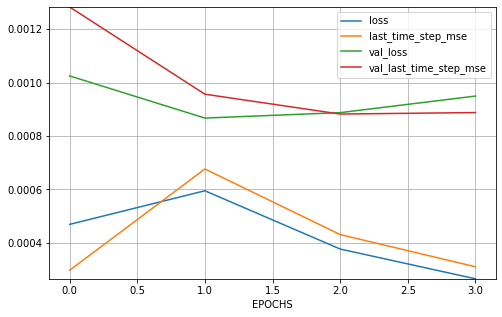

In [5258]:
#plot the learning curve of the model
plot_learning_curve(history2)
plt.show()

In [5259]:
y_pred2 = model2.predict(testSeries2)

In [5260]:
y_pred2.shape

(862, 2, 5)

In [5261]:
actual2 = indexScaler.inverse_transform( y_test2[:-2,:] )
pred2 = indexScaler.inverse_transform( y_pred2[:,0] )

np.mean(keras.losses.mean_absolute_error( actual2, pred2))

88.51778

In [ ]:
#plot the actual values vs. the predictions
plot_actual_pred ( actual2[:,0], pred2[:,0] )


In [ ]:
#forecast the next X items in the sequence
plot_forecast(actual2[-100:,0], pred2[-1], actual2[-1] )

In [5059]:
#predcition is based on last observed value
pred3= indexScaler.inverse_transform( y_test2[1:,] )
actual3= indexScaler.inverse_transform( y_test2[:-1,] )

#calculate the Mean Absolute Error between the prediction and the actual
naive2 = np.mean(keras.losses.mean_absolute_error(pred3,actual3))
naive2

23.39680648899189

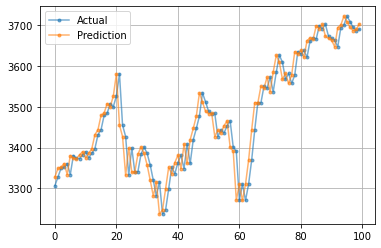

In [5060]:
plot_actual_pred (actual3[-100:,0], pred3[-100:,0])

# One Stock Analysis

<AxesSubplot:>

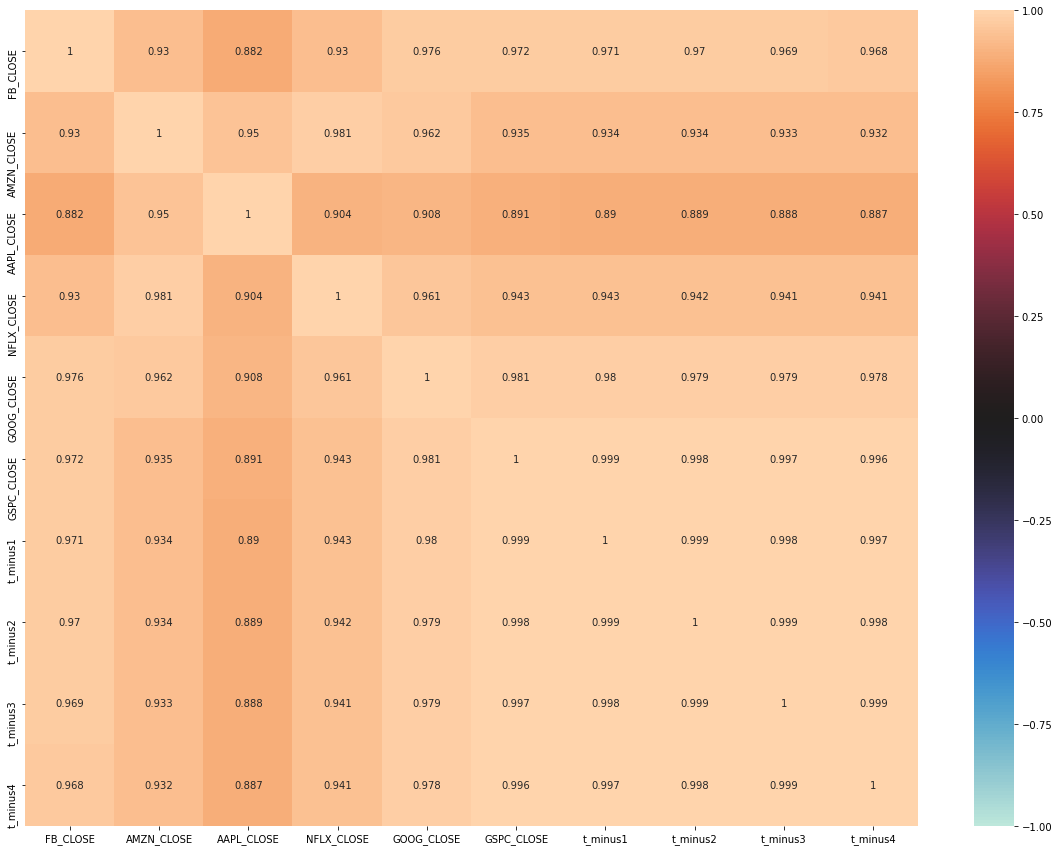

In [5061]:
#Google has the highest correlation

data.corr()

import seaborn as sns

fig, ax = plt.subplots(figsize=(20,15))   
sns.heatmap(data.corr(), annot = True, fmt ='.3g',vmin=-1, vmax=1, center= 0,ax=ax)

In [3042]:
GoogScaled=scaled_data[:,5:]

In [3043]:
GoogScaled.shape

(2165, 5)

In [3044]:
#let's determine the number of features in our data
#we need this information for building out our model in the future
num_features = GoogScaled.shape[1]
num_features

5

In [3545]:
#take a look at the first 5 entries that will be the "features" for this model
GoogScaled[0:5]

array([[0.01735224, 0.01661159, 0.0157041 , 0.01552503, 0.01605307],
       [0.01618837, 0.01735224, 0.01661159, 0.01578685, 0.02194485],
       [0.0221298 , 0.01618837, 0.01735224, 0.01669912, 0.01423712],
       [0.0143571 , 0.0221298 , 0.01618837, 0.01744367, 0.01303051],
       [0.01314033, 0.0143571 , 0.0221298 , 0.01627367, 0.        ]])

In [3546]:
#take a look at the first 15 entries in the data that will be used as the labeled data (y) for our model
#NOTE: that num_features-1 after the commas indicateds to select the last column in our dataset as the labeled data
Y_Goog = pd.DataFrame(GoogScaled[:,0])
Y_Goog['t_plus1'] =Y_Goog[0].shift(-1)
Y_Goog.head(10)

,0,t_plus1
0,0.017352,0.016188
1,0.016188,0.022130
2,0.022130,0.014357
3,0.014357,0.013140
4,0.013140,0.000000
5,0.000000,0.000057
6,0.000057,0.003036
7,0.003036,0.015094
8,0.015094,0.015037
9,0.015037,0.019379


In [3547]:
Y_Goog.tail()

,0,t_plus1
2160,0.981545,0.986856
2161,0.986856,1.000000
2162,1.000000,0.996614
2163,0.996614,0.998649
2164,0.998649,NaN


In [3548]:
Y_Goog.dropna(inplace=True)

In [3549]:
Y_Goog = Y_Goog.to_numpy()

In [3550]:
GoogScaled[0:15,num_features-1]

array([1.60530744e-02, 2.19448514e-02, 1.42371158e-02, 1.30305121e-02,
       0.00000000e+00, 5.64964912e-05, 3.01045589e-03, 1.49675347e-02,
       1.49110382e-02, 1.92168779e-02, 1.24655472e-02, 1.86196293e-02,
       1.48666481e-02, 2.06050774e-02, 2.61498045e-02])

In [3551]:
# split into train and test sets
X_train_Goog, X_test_Goog, y_train_Goog, y_test_Goog = train_test_split(GoogScaled[:-1,], Y_Goog[:,1:], test_size=0.40, random_state=42, shuffle = False)
X_train_Goog, X_valid_Goog, y_train_Goog, y_valid_Goog = train_test_split(X_train_Goog,y_train_Goog, test_size=0.40, random_state=42, shuffle = False)

In [3552]:
X_train_Goog.shape, X_valid_Goog.shape, X_test_Goog.shape, y_train_Goog.shape

((778, 5), (520, 5), (866, 5), (778, 1))

In [3553]:
y_train

array([[2.19448514e-02],
       [1.42371158e-02],
       [1.30305121e-02],
       [0.00000000e+00],
       [5.64964912e-05],
       [3.01045589e-03],
       [1.49675347e-02],
       [1.49110382e-02],
       [1.92168779e-02],
       [1.24655472e-02],
       [1.86196293e-02],
       [1.48666481e-02],
       [2.06050774e-02],
       [2.61498045e-02],
       [2.69326844e-02],
       [3.22594965e-02],
       [3.13353753e-02],
       [1.91563460e-02],
       [2.29940719e-02],
       [1.43985343e-02],
       [1.69287700e-02],
       [2.17148299e-02],
       [2.05808646e-02],
       [3.39463203e-02],
       [3.52982006e-02],
       [3.87323802e-02],
       [3.61335416e-02],
       [3.09277934e-02],
       [3.00319205e-02],
       [2.55969460e-02],
       [2.55888750e-02],
       [2.28891498e-02],
       [3.17752408e-02],
       [3.05081052e-02],
       [3.45556753e-02],
       [3.82319827e-02],
       [3.97372106e-02],
       [3.41480934e-02],
       [2.92490406e-02],
       [2.43217394e-02],


In [3554]:

STEPS = 7

In [3555]:
trainSeries_Goog = keras.preprocessing.sequence.TimeseriesGenerator(X_train_Goog, y_train_Goog, length=STEPS, batch_size=1)
testSeries_Goog = keras.preprocessing.sequence.TimeseriesGenerator(X_test_Goog, y_test_Goog, length=STEPS, batch_size=1)
validSeries_Goog = keras.preprocessing.sequence.TimeseriesGenerator(X_valid_Goog,y_valid_Goog,length=STEPS, batch_size=1)

In [3556]:
#starting by setting random seeds and restarting keras blackend session
np.random.seed(42)
tf.random.set_seed(42)

#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

In [3557]:
#now let's try this using LSTMs which by its nature takes into consideration 
#long-term trends as well as learning from newer data
#we just changed our RNN layers to LSTM layers

model_Goog = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=(STEPS, num_features)),
    keras.layers.GRU(10, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

In [3558]:
model_Goog.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 7, 20)             1620      
_________________________________________________________________
gru_1 (GRU)                  (None, 7, 10)             960       
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 1)              11        
Total params: 2,591
Trainable params: 2,591
Non-trainable params: 0
_________________________________________________________________


In [3559]:
#compile the model and use the new metric defined in the previous step
model_Goog.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.0001), metrics=[last_time_step_mse])

#fit the model
history_Goog = model_Goog.fit(trainSeries_Goog, epochs=500, shuffle=False, 
                    validation_data=validSeries_Goog, callbacks=[early_stopping])

Epoch 1/500
771/771 [==============================] - 8s 5ms/step - loss: 4.7959e-04 - last_time_step_mse: 1.4496e-04 - val_loss: 0.0026 - val_last_time_step_mse: 0.0025
Epoch 2/500
771/771 [==============================] - 4s 5ms/step - loss: 0.0035 - last_time_step_mse: 0.0035 - val_loss: 0.0013 - val_last_time_step_mse: 9.1309e-04
Epoch 3/500
771/771 [==============================] - 4s 5ms/step - loss: 0.0016 - last_time_step_mse: 0.0014 - val_loss: 7.6195e-04 - val_last_time_step_mse: 5.2242e-04
Epoch 4/500
771/771 [==============================] - 4s 5ms/step - loss: 8.3883e-04 - last_time_step_mse: 6.4767e-04 - val_loss: 5.5024e-04 - val_last_time_step_mse: 3.9095e-04
Epoch 5/500
771/771 [==============================] - 4s 5ms/step - loss: 4.8971e-04 - last_time_step_mse: 3.4954e-04 - val_loss: 4.6566e-04 - val_last_time_step_mse: 3.5360e-04
Epoch 6/500
771/771 [==============================] - 4s 5ms/step - loss: 3.3876e-04 - last_time_step_mse: 2.3723e-04 - val_loss: 4.

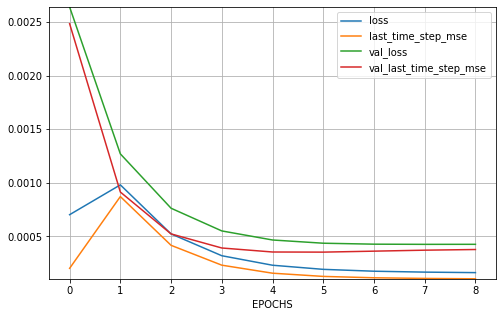

In [3560]:
#plot the learning curve of the model
plot_learning_curve(history_Goog)
plt.show()

In [3561]:
y_pred_Goog = model_Goog.predict(testSeries_Goog)

In [3562]:
actual_Goog = indexScaler.inverse_transform( y_test_Goog[:-STEPS] )
pred_Goog = indexScaler.inverse_transform( y_pred_Goog[:,0] )

np.mean(keras.losses.mean_absolute_error( actual_Goog, pred_Goog))

32.830322

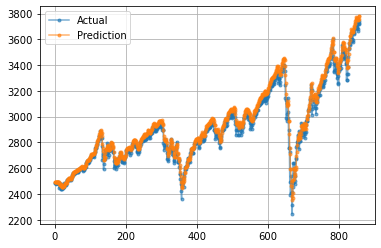

In [3563]:
#plot the actual values vs. the predictions
plot_actual_pred ( actual_Goog[:,0], pred_Goog[:,0] )


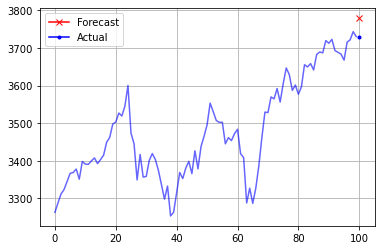

In [3155]:
#forecast the next X items in the sequence
plot_forecast(actual_Goog[-100:,0], pred_Goog[-1], actual_Goog[-1] )

In [3156]:


#predcition is based on last observed value
goog_pred= indexScaler.inverse_transform( y_test_Goog[1:,].reshape(-1,1) )
goog_actual= indexScaler.inverse_transform( y_test_Goog[:-1,].reshape(-1,1) )

#calculate the Mean Absolute Error between the prediction and the actual
goog_naive = np.mean(keras.losses.mean_absolute_error(goog_pred,goog_actual))
goog_naive

23.549449068909034

In [3157]:
#starting by setting random seeds and restarting keras blackend session
np.random.seed(42)
tf.random.set_seed(42)

#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

In [3158]:
model_Goog2 = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=(STEPS, num_features)),
    keras.layers.LSTM(10, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

In [3159]:
##Using LSTM

model_Goog2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 20)             2080      
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 10)             1240      
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 1)              11        
Total params: 3,331
Trainable params: 3,331
Non-trainable params: 0
_________________________________________________________________


In [3160]:
early_stopping_Goog = keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode='min', min_delta=.001)

In [3161]:
#compile the model and use the new metric defined in the previous step
model_Goog2.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.0001), metrics=[last_time_step_mse])

#fit the model
history_Goog2 = model_Goog2.fit(trainSeries_Goog, epochs=500, shuffle=False, 
                    validation_data=validSeries_Goog, callbacks=[early_stopping_Goog])

Epoch 1/500
771/771 [==============================] - 6s 5ms/step - loss: 0.0014 - last_time_step_mse: 3.6150e-04 - val_loss: 0.0069 - val_last_time_step_mse: 0.0070
Epoch 2/500
771/771 [==============================] - 3s 4ms/step - loss: 0.0071 - last_time_step_mse: 0.0086 - val_loss: 0.0045 - val_last_time_step_mse: 0.0036
Epoch 3/500
771/771 [==============================] - 3s 4ms/step - loss: 0.0041 - last_time_step_mse: 0.0038 - val_loss: 0.0029 - val_last_time_step_mse: 0.0020
Epoch 4/500
771/771 [==============================] - 3s 4ms/step - loss: 0.0022 - last_time_step_mse: 0.0015 - val_loss: 0.0017 - val_last_time_step_mse: 0.0011
Epoch 5/500
771/771 [==============================] - 3s 4ms/step - loss: 0.0012 - last_time_step_mse: 5.7426e-04 - val_loss: 0.0012 - val_last_time_step_mse: 7.9886e-04
Epoch 6/500
771/771 [==============================] - 3s 4ms/step - loss: 6.9985e-04 - last_time_step_mse: 2.6012e-04 - val_loss: 9.8930e-04 - val_last_time_step_mse: 7.578

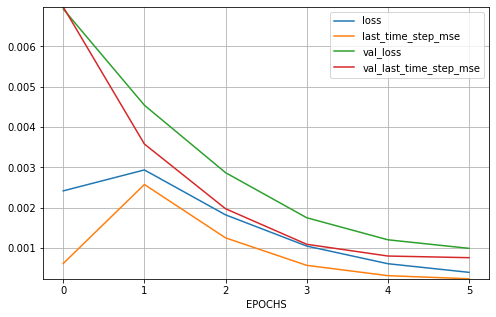

In [3162]:
#plot the learning curve of the model
plot_learning_curve(history_Goog2)
plt.show()

In [3163]:
y_pred_Goog2 = model_Goog2.predict(testSeries_Goog)

In [3164]:
actual_Goog2 = indexScaler.inverse_transform( y_test_Goog[:-STEPS] )
pred_Goog2 = indexScaler.inverse_transform( y_pred_Goog2[:,0] )

np.mean(keras.losses.mean_absolute_error( actual_Goog2, pred_Goog2))

119.247314

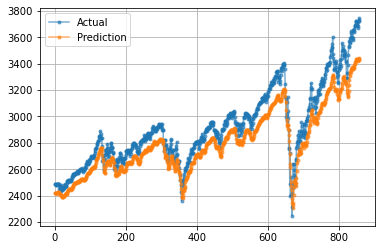

In [3165]:
#plot the actual values vs. the predictions
plot_actual_pred ( actual_Goog2[:,0], pred_Goog2[:,0] )


# Use only Goog to predict S&P

In [3481]:
Y_GoogSP = pd.DataFrame(GoogScaled[:,-1])
Y_GoogSP['t_plus1'] =Y_GoogSP[0].shift(-1)
Y_GoogSP.head(10)

,0,t_plus1
0,0.016053,0.021945
1,0.021945,0.014237
2,0.014237,0.013031
3,0.013031,0.000000
4,0.000000,0.000056
5,0.000056,0.003010
6,0.003010,0.014968
7,0.014968,0.014911
8,0.014911,0.019217
9,0.019217,0.012466


In [3482]:
Y_GoogSP.tail()

,0,t_plus1
2160,0.978608,0.991643
2161,0.991643,0.988285
2162,0.988285,0.990303
2163,0.990303,1.000000
2164,1.000000,NaN


In [3483]:
Y_GoogSP.dropna(inplace=True)

In [3484]:
Y_GoogSP = Y_GoogSP.to_numpy()

In [3485]:
GoogScaled[0:15,num_features-1]

array([1.60530744e-02, 2.19448514e-02, 1.42371158e-02, 1.30305121e-02,
       0.00000000e+00, 5.64964912e-05, 3.01045589e-03, 1.49675347e-02,
       1.49110382e-02, 1.92168779e-02, 1.24655472e-02, 1.86196293e-02,
       1.48666481e-02, 2.06050774e-02, 2.61498045e-02])

In [3486]:
# split into train and test sets
X_train_GoogSP, X_test_GoogSP, y_train_GoogSP, y_test_GoogSP = train_test_split(GoogScaled[:-1,], Y_GoogSP[:,1:], test_size=0.40, random_state=42, shuffle = False)
X_train_GoogSP, X_valid_GoogSP, y_train_GoogSP, y_valid_GoogSP = train_test_split(X_train_GoogSP,y_train_GoogSP, test_size=0.40, random_state=42, shuffle = False)

In [3487]:
X_train_GoogSP.shape, X_valid_GoogSP.shape, X_test_GoogSP.shape, y_train_GoogSP.shape

((778, 5), (520, 5), (866, 5), (778, 1))

In [3488]:
STEPS=2

In [3489]:
trainSeries_GoogSP = keras.preprocessing.sequence.TimeseriesGenerator(X_train_Goog, y_train_Goog, length=STEPS, batch_size=10)
testSeries_GoogSP = keras.preprocessing.sequence.TimeseriesGenerator(X_test_Goog, y_test_Goog, length=STEPS, batch_size=10)
validSeries_GoogSP = keras.preprocessing.sequence.TimeseriesGenerator(X_valid_Goog,y_valid_Goog,length=STEPS, batch_size=10)

In [3490]:
#starting by setting random seeds and restarting keras blackend session
np.random.seed(42)
tf.random.set_seed(42)

#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

In [3491]:
#now let's try this using LSTMs which by its nature takes into consideration 
#long-term trends as well as learning from newer data
#we just changed our RNN layers to LSTM layers

model_GoogSP = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=(STEPS, num_features)),
    keras.layers.GRU(10, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

In [3492]:
model_GoogSP.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 2, 20)             1620      
_________________________________________________________________
gru_1 (GRU)                  (None, 2, 10)             960       
_________________________________________________________________
time_distributed (TimeDistri (None, 2, 1)              11        
Total params: 2,591
Trainable params: 2,591
Non-trainable params: 0
_________________________________________________________________


In [3493]:
#compile the model and use the new metric defined in the previous step
model_GoogSP.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.0001), metrics=[last_time_step_mse])

#fit the model
history_GoogSP = model_GoogSP.fit(trainSeries_GoogSP, epochs=500, shuffle=False, 
                    validation_data=validSeries_GoogSP, callbacks=[early_stopping])

Epoch 1/500
78/78 [==============================] - 3s 11ms/step - loss: 0.0073 - last_time_step_mse: 0.0045 - val_loss: 0.0298 - val_last_time_step_mse: 0.0087
Epoch 2/500
78/78 [==============================] - 0s 3ms/step - loss: 0.0038 - last_time_step_mse: 0.0032 - val_loss: 0.0182 - val_last_time_step_mse: 8.7392e-04
Epoch 3/500
78/78 [==============================] - 0s 3ms/step - loss: 0.0054 - last_time_step_mse: 0.0070 - val_loss: 0.0154 - val_last_time_step_mse: 5.6446e-04
Epoch 4/500
78/78 [==============================] - 0s 3ms/step - loss: 0.0056 - last_time_step_mse: 0.0074 - val_loss: 0.0141 - val_last_time_step_mse: 5.9322e-04
Epoch 5/500
78/78 [==============================] - 0s 3ms/step - loss: 0.0052 - last_time_step_mse: 0.0069 - val_loss: 0.0129 - val_last_time_step_mse: 6.2462e-04
Epoch 6/500
78/78 [==============================] - 0s 3ms/step - loss: 0.0048 - last_time_step_mse: 0.0062 - val_loss: 0.0117 - val_last_time_step_mse: 6.6150e-04
Epoch 7/500
7

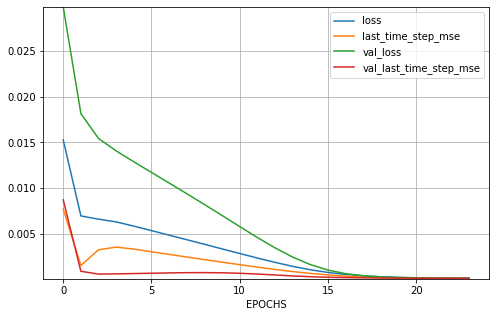

In [3494]:
#plot the learning curve of the model
plot_learning_curve(history_GoogSP)
plt.show()

In [3495]:
y_pred_GoogSP = model_GoogSP.predict(testSeries_GoogSP)

In [3496]:
actual_GoogSP = indexScaler.inverse_transform( y_test_GoogSP[:-STEPS] )
pred_GoogSP = indexScaler.inverse_transform( y_pred_GoogSP[:,0] )

np.mean(keras.losses.mean_absolute_error( actual_GoogSP, pred_GoogSP))

32.517857

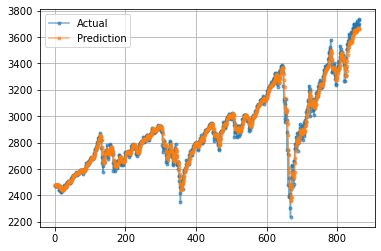

In [3497]:
#plot the actual values vs. the predictions
plot_actual_pred ( actual_GoogSP[:,0], pred_GoogSP[:,0] )


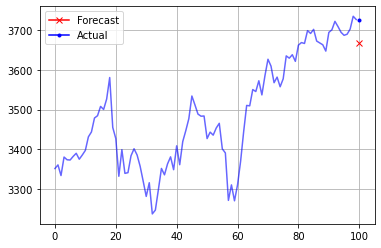

In [3498]:
#forecast the next X items in the sequence
plot_forecast(actual_GoogSP[-100:,0], pred_GoogSP[-1], actual_GoogSP[-1] )

In [3184]:


#predcition is based on last observed value
goog_predSP= indexScaler.inverse_transform( y_test_GoogSP[1:,].reshape(-1,1) )
goog_actualSP= indexScaler.inverse_transform( y_test_GoogSP[:-1,].reshape(-1,1) )

#calculate the Mean Absolute Error between the prediction and the actual
goog_naiveSP = np.mean(keras.losses.mean_absolute_error(goog_predSP,goog_actualSP))
goog_naiveSP

23.37960693641618

# One Stock Analysis - Linear Model

In [701]:
#starting by setting random seeds and restarting keras blackend session
np.random.seed(42)
tf.random.set_seed(42)

#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

In [702]:
model_lin = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(1)
])

In [703]:
#compile and fit the model
#note we are using the metric Mean Absolute Error for tempertatures
model_lin.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.0001), metrics=[last_time_step_mse])

In [704]:
#fit the model 
#NOTE: Because we are workign with a continuous series, shuffle=False is needed
history_lin = model_lin.fit(trainSeries_Goog, epochs=500, validation_data=validSeries_Goog, shuffle=False, callbacks=[early_stopping])

Epoch 1/500
748/748 [==============================] - 1s 977us/step - loss: 3.1972e-04 - last_time_step_mse: 3.1972e-04 - val_loss: 6.8040e-04 - val_last_time_step_mse: 6.8040e-04
Epoch 2/500
748/748 [==============================] - 1s 818us/step - loss: 2.2217e-04 - last_time_step_mse: 2.2217e-04 - val_loss: 6.6876e-04 - val_last_time_step_mse: 6.6876e-04
Epoch 3/500
748/748 [==============================] - 1s 833us/step - loss: 2.0644e-04 - last_time_step_mse: 2.0644e-04 - val_loss: 6.5755e-04 - val_last_time_step_mse: 6.5755e-04
Epoch 4/500
748/748 [==============================] - 1s 831us/step - loss: 1.9696e-04 - last_time_step_mse: 1.9696e-04 - val_loss: 6.4597e-04 - val_last_time_step_mse: 6.4597e-04
Epoch 5/500
748/748 [==============================] - 1s 815us/step - loss: 1.9092e-04 - last_time_step_mse: 1.9092e-04 - val_loss: 6.3374e-04 - val_last_time_step_mse: 6.3374e-04
Epoch 6/500
748/748 [==============================] - 1s 838us/step - loss: 1.8670e-04 - last_

748/748 [==============================] - 1s 827us/step - loss: 1.0628e-04 - last_time_step_mse: 1.0628e-04 - val_loss: 3.1523e-04 - val_last_time_step_mse: 3.1523e-04
Epoch 47/500
748/748 [==============================] - 1s 829us/step - loss: 1.0586e-04 - last_time_step_mse: 1.0586e-04 - val_loss: 3.1461e-04 - val_last_time_step_mse: 3.1461e-04
Epoch 48/500
748/748 [==============================] - 1s 829us/step - loss: 1.0547e-04 - last_time_step_mse: 1.0547e-04 - val_loss: 3.1411e-04 - val_last_time_step_mse: 3.1411e-04
Epoch 49/500
748/748 [==============================] - 1s 816us/step - loss: 1.0510e-04 - last_time_step_mse: 1.0510e-04 - val_loss: 3.1370e-04 - val_last_time_step_mse: 3.1370e-04
Epoch 50/500
748/748 [==============================] - 1s 824us/step - loss: 1.0477e-04 - last_time_step_mse: 1.0477e-04 - val_loss: 3.1336e-04 - val_last_time_step_mse: 3.1336e-04


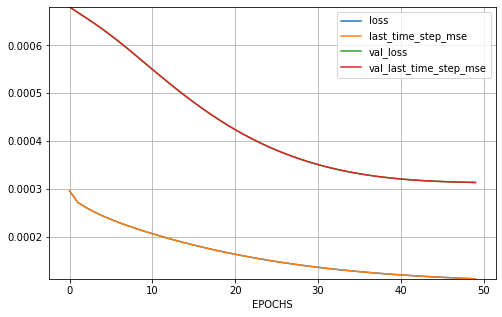

In [705]:
#see that the learning curve is ideal
plot_learning_curve( history_lin )

In [707]:
y_pred_lin = model_lin.predict(testSeries_Goog)

In [711]:
actual_lin = indexScaler.inverse_transform( y_test_Goog[:-STEPS].reshape(-1,1) )
pred_lin = indexScaler.inverse_transform( y_pred_lin[:,0].reshape(-1,1) )

np.mean(keras.losses.mean_absolute_error( actual_lin, pred_lin))

75.21136

# One Stock Analysis - Simple RNN

In [3512]:
#starting by setting random seeds and restarting keras blackend session
np.random.seed(42)
tf.random.set_seed(42)

#resets the Keras global state - helps avoid clutter from old models and layers, especially when memory is limited
keras.backend.clear_session()

In [3513]:
#this is a very similar model to the last one but will run faster and provides flexibility in the output layer
model_simp = keras.models.Sequential([
    keras.layers.SimpleRNN(100, return_sequences=True, input_shape=(2, 5)), 
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

In [3514]:
trainSeries_simp = keras.preprocessing.sequence.TimeseriesGenerator(X_train_Goog, y_train_Goog, length=2, batch_size=10)
testSeries_simp = keras.preprocessing.sequence.TimeseriesGenerator(X_test_Goog, y_test_Goog, length=2, batch_size=10)
validSeries_simp = keras.preprocessing.sequence.TimeseriesGenerator(X_valid_Goog,y_valid_Goog,length=2, batch_size=10)

In [3515]:
early_stopping2 = keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, mode='min', min_delta=.00001)

In [3516]:
#compile the model and use the new metric defined in the previous step
model_simp.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.000001), metrics=[last_time_step_mse])

#fit the model
history_simp = model_simp.fit(trainSeries_simp, epochs=500, shuffle=False, 
                    validation_data=validSeries_simp, callbacks=[early_stopping2])

Epoch 1/500
78/78 [==============================] - 3s 5ms/step - loss: 0.0390 - last_time_step_mse: 0.0390 - val_loss: 0.2436 - val_last_time_step_mse: 0.2442
Epoch 2/500
78/78 [==============================] - 0s 2ms/step - loss: 0.0352 - last_time_step_mse: 0.0352 - val_loss: 0.2264 - val_last_time_step_mse: 0.2270
Epoch 3/500
78/78 [==============================] - 0s 2ms/step - loss: 0.0323 - last_time_step_mse: 0.0323 - val_loss: 0.2107 - val_last_time_step_mse: 0.2113
Epoch 4/500
78/78 [==============================] - 0s 2ms/step - loss: 0.0296 - last_time_step_mse: 0.0296 - val_loss: 0.1962 - val_last_time_step_mse: 0.1967
Epoch 5/500
78/78 [==============================] - 0s 2ms/step - loss: 0.0272 - last_time_step_mse: 0.0272 - val_loss: 0.1825 - val_last_time_step_mse: 0.1830
Epoch 6/500
78/78 [==============================] - 0s 2ms/step - loss: 0.0249 - last_time_step_mse: 0.0249 - val_loss: 0.1696 - val_last_time_step_mse: 0.1701
Epoch 7/500
78/78 [===============

Epoch 100/500
78/78 [==============================] - 0s 2ms/step - loss: 4.5008e-04 - last_time_step_mse: 4.5006e-04 - val_loss: 7.5502e-04 - val_last_time_step_mse: 7.6440e-04
Epoch 101/500
78/78 [==============================] - 0s 2ms/step - loss: 4.3233e-04 - last_time_step_mse: 4.3231e-04 - val_loss: 7.3465e-04 - val_last_time_step_mse: 7.4380e-04
Epoch 102/500
78/78 [==============================] - 0s 2ms/step - loss: 4.1503e-04 - last_time_step_mse: 4.1501e-04 - val_loss: 7.1476e-04 - val_last_time_step_mse: 7.2368e-04
Epoch 103/500
78/78 [==============================] - 0s 2ms/step - loss: 3.9819e-04 - last_time_step_mse: 3.9818e-04 - val_loss: 6.9534e-04 - val_last_time_step_mse: 7.0403e-04
Epoch 104/500
78/78 [==============================] - 0s 2ms/step - loss: 3.8182e-04 - last_time_step_mse: 3.8180e-04 - val_loss: 6.7640e-04 - val_last_time_step_mse: 6.8487e-04
Epoch 105/500
78/78 [==============================] - 0s 2ms/step - loss: 3.6591e-04 - last_time_step_ms

Epoch 146/500
78/78 [==============================] - 0s 2ms/step - loss: 7.1719e-05 - last_time_step_mse: 7.1724e-05 - val_loss: 2.5223e-04 - val_last_time_step_mse: 2.5504e-04
Epoch 147/500
78/78 [==============================] - 0s 2ms/step - loss: 7.0639e-05 - last_time_step_mse: 7.0645e-05 - val_loss: 2.4882e-04 - val_last_time_step_mse: 2.5157e-04
Epoch 148/500
78/78 [==============================] - 0s 2ms/step - loss: 6.9687e-05 - last_time_step_mse: 6.9692e-05 - val_loss: 2.4560e-04 - val_last_time_step_mse: 2.4830e-04
Epoch 149/500
78/78 [==============================] - 0s 2ms/step - loss: 6.8849e-05 - last_time_step_mse: 6.8855e-05 - val_loss: 2.4256e-04 - val_last_time_step_mse: 2.4521e-04
Epoch 150/500
78/78 [==============================] - 0s 2ms/step - loss: 6.8117e-05 - last_time_step_mse: 6.8123e-05 - val_loss: 2.3970e-04 - val_last_time_step_mse: 2.4230e-04
Epoch 151/500
78/78 [==============================] - 0s 2ms/step - loss: 6.7480e-05 - last_time_step_ms

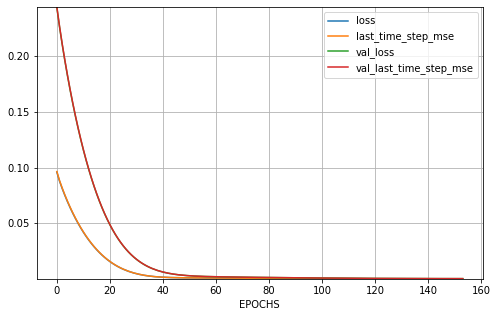

In [3520]:
#plot the learning curve of the model
plot_learning_curve(history_simp)
plt.show()

In [3521]:
y_pred_simp = model_simp.predict(testSeries_simp)

In [3525]:
actual_simp = indexScaler.inverse_transform( y_test_Goog[:-2].reshape(-1,1) )
pred_simp = indexScaler.inverse_transform( y_pred_simp[:,0].reshape(-1,1) )

np.mean(keras.losses.mean_absolute_error( actual_simp, pred_simp))

184.2911

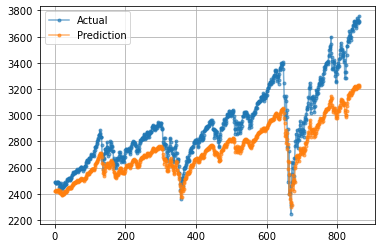

In [3526]:
#plot the actual values vs. the predictions
plot_actual_pred ( actual_simp[:,0], pred_simp[:,0] )


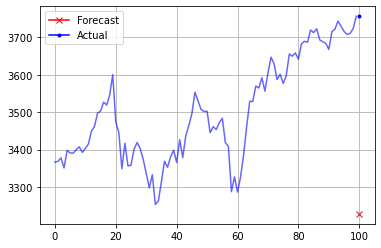

In [3527]:
#forecast the next X items in the sequence
plot_forecast(actual_simp[-100:,0], pred_simp[-1], actual_simp[-1] )